# MMR Predictor
Predicting MMR of a *League of Legends* match using Recurrent Neural Network model

In [117]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math
from typing import Dict, List
from torch.utils.data import Dataset, DataLoader
import random

## Constants/Hyperparameters

In [77]:
# Data split
TRAIN_RAT = 0.6
VALID_RAT = 0.2
TEST_RAT = 1 - TRAIN_RAT - VALID_RAT

## Data Processing

In [118]:
def calculate_avg_mmr(elo_ratings):
    """
    Calculate the average value of 10 players' ELO ratings.
    Return -1 if the avg is out of bounds (0 - 3386)
    """
    ret = math.floor(sum(elo_ratings)/len(elo_ratings))
    if ret < 0 or ret > 3386:
        return -1
    
    return ret


def classify_elo(elo):
    """
    Return the index representing a ranking system in League of Legends.
    
    Iron IV, III, II, I = 0, 1, 2, 3
    Bronze IV, III, II, I = 4, 5, 6, 7
    Silver IV, III, II, I = 8, 9, 10, 11
    Gold IV, III, II, I = 12, 13, 14, 15
    Platinum IV, III, II, I = 16, 17, 18, 19
    Diamond IV, III, II, I = 20, 21, 22, 23
    Master = 24
    Grandmaster = 25
    Challengers = 26
    """
    if elo == -1:
        return -1 
    
    mmr_ranges = [
        [0, 112], [112, 227], [227, 479], [497, 579], # Iron
        [579, 757], [757, 963], [963, 1094], [1094, 1207], # Bronze
        [1207, 1308], [1308, 1418], [1418, 1528], [1528, 1619], # Silver
        [1619, 1702], [1702, 1793], [1793, 1896], [1896, 1980], # Gold
        [1980, 2045], [2045, 2146], [2146, 2255], [2255, 2329], # Platinum
        [2329, 2396], [2396, 2487], [2487, 2602], [2602, 2729], # Diamond
        [2729, 2893], # Master
        [2893, 3126], # Grandmaster 
        [3126, 3386] # Challenger
    ]
    for i in range(len(mmr_ranges)):
        if mmr_ranges[i][0] <= elo < mmr_ranges[i][1]:
            return i//4
    
    return -1 


def process_data():
    """
    # TODO: Add documentation
    """
    data = []
    failed = 0
    path = os.getcwd() + '/DataCollection/data/'
    matches = os.listdir(path)
    for file_name in matches:
        try:
            with open(path + file_name) as f:
                raw_data = json.load(f)
                if raw_data['timeline'] and raw_data['elo'] and len(raw_data['timeline']) >= 15:
                    avg_mmr = calculate_avg_mmr(raw_data['elo'])
                    target_elos = classify_elo(avg_mmr)
                    x = torch.tensor(raw_data['timeline'][:15]) # only take the first 15 minutes
                    t = F.one_hot(torch.tensor(target_elos), num_classes=7)
                    data.append((x, t))
        except:
            failed += 1

    print("{} data are not valid and cannot be processed.".format(failed))
    random.shuffle(data)
    return data


def split_data(data, train_rat=TRAIN_RAT, valid_rat=VALID_RAT): # TODO: change values
    n_train = math.floor(len(data) * train_rat)
    n_val = math.floor(len(data) * valid_rat)
    
    return data[:n_train], data[n_train:n_train+n_val], data[n_train+n_val:]


def data_summary(data):
    data_len = len(data)
    one_dim = data[0][0].size()
    train_data_len = math.floor(len(data) * TRAIN_RAT)
    valid_data_len = math.floor(len(data) * VALID_RAT)
    test_data_len = data_len - train_data_len - valid_data_len
    
    s = "-- Data Summary --" + \
        "\nTotal datapoints = " + str(data_len) + \
        "\nNo. of Training Data = " + str(train_data_len) + \
        "\nNo. of Validation Data = " + str(valid_data_len) + \
        "\nNo. of Test Data = " + str(test_data_len) + \
        "\nSingle datapoint shape = " + str(one_dim)
    
    return s


In [119]:
data = process_data()
train_data, valid_data, test_data = split_data(data)

1739 data are not valid and cannot be processed.


In [120]:
print(data_summary(data))


-- Data Summary --
Total datapoints = 8455
No. of Training Data = 5073
No. of Validation Data = 1691
No. of Test Data = 1691
Single datapoint shape = torch.Size([15, 50])


## RNN Model

In [121]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=15, num_classes=7):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        h0 = h0.cuda()
        c0 = c0.cuda()
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        # out, _ = self.rnn(x, h0)  
        # or:
        x = x.cuda()
        out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        out = self.fc(out)
        # out = self.tanh(out)
    
        return out



## Training the Model

In [122]:
def plot_training_curves(iters, losses, train_acc):
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Loss")
    plt.plot(iters, train_acc, label="Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Loss/Accuracy")
    plt.legend(["Loss", "Accuracy"])
    plt.show()

    
def get_accuracy(model, data):
    """
    #TODO: brief explanation on what correct prediction is
    """
    loader = torch.utils.data.DataLoader(data, batch_size=256, shuffle=True)
    model.eval()
    
    correct = 0
    total = 0
    
    for matches, target_elos in loader:
        matches = matches.type(torch.FloatTensor)
        matches = matches.cuda()
        target_elos = target_elos.cuda()
        generated_mmr = model(matches)
  
        pred = generated_mmr.argmax(1, keepdim=True)
        target = target_elos.argmax(1, keepdim=True)
        # print(pred)
        # print(target)
        # break;
        correct += pred.eq(target).sum().item()
        total += matches.shape[0]
        
    return correct/total



In [123]:
def training(model, train_data, valid_data=None, \
             batch_size=256, \
             weight_decay=0.0, \
             learning_rate=0.001, \
             num_epochs=7, \
             max_iters=1000, \
             checkpoint_path=None, \
             momentum=0.9, \
             save_after=100):
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
    
    # We use Cross-Entropy Loss function and Adam optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    iters, losses, train_acc, val_acc = [], [], [], []
    n = 0
    for epoch in range(num_epochs):
        tacc, vacc = 0, 0
        for matches, target_elos in iter(train_loader):
            if matches.size()[0] < batch_size:
                continue

            matches = matches.type(torch.FloatTensor)   
            target_elos = target_elos.type(torch.FloatTensor)
            model.train()
            model.cuda()
            matches = matches.cuda()
            target_elos = target_elos.cuda()
            output = model(matches) # forward pass
            output = output.cuda()
            
            loss = criterion(output, target_elos)
            loss.backward() # backward pass
            optimizer.step()
            optimizer.zero_grad()
            
            iters.append(n)
            n += 1
            losses.append(float(loss)/batch_size)
            tacc = get_accuracy(model, train_data)
            train_acc.append(tacc)
            
            if valid_data is not None:
                vacc = get_accuracy(model, valid_data)
                val_acc.append(vacc)

        print("Epoch %d. [Train Acc %.0f%%] [Val Acc %.0f%%]" % (epoch, tacc * 100, vacc * 100))

        #torch.save(model.state_dict(), checkpoint_path.format(n))
       
    return iters, losses, train_acc, val_acc



In [142]:
model = RNN(50, hidden_size=64)
model.cuda()

iters, losses, train_acc, val_acc = training(model, train_data, valid_data, \
                                             batch_size=32, \
                                             weight_decay=0.0, \
                                             learning_rate=0.1, \
                                             num_epochs=3, \
                                             max_iters=1000, \
                                             checkpoint_path=None, \
                                             momentum=0.0, \
                                             save_after=100) # MODEL NOT FIXED YET

Epoch 0. [Train Acc 31%] [Val Acc 30%]
Epoch 1. [Train Acc 31%] [Val Acc 30%]
Epoch 2. [Train Acc 31%] [Val Acc 30%]


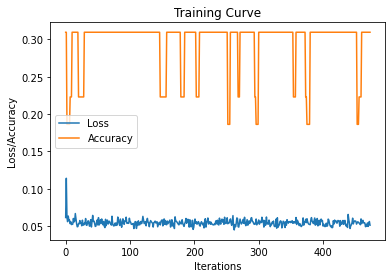

In [143]:
plot_training_curves(iters, losses, train_acc)

In [144]:
test_accuracy = get_accuracy(model, test_data)

In [145]:
print("-- MMR Predictor Accuracy Results: --")
print("\nTraining Accuracy: ", train_acc[-1]*100)
print("\nValidation Accuracy: ", val_acc[-1]*100)
print("\nTest Accuracy: ", test_accuracy*100)

-- MMR Predictor Accuracy Results: --

Training Accuracy:  30.94815690912675

Validation Accuracy:  30.100532229450028

Test Accuracy:  29.863985807214664
